In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

plt.rcParams['image.cmap'] = 'seismic'

In [3]:
north = Table.read('/Users/rongpu/Data/dr9_tests/sky_residuals/survey_bricks_optical_sky_residuals-dr9_north.fits')
south = Table.read('/Users/rongpu/Data/dr9_tests/sky_residuals/survey_bricks_optical_sky_residuals-dr9_south.fits')

mask = (north['DEC']>32.375) & ((north['RA']>60) & (north['RA']<300))
mask &= (north['g_median']!=-99) & (north['r_median']!=-99) & (north['z_median']!=-99)
north = north[mask]
print(len(north), len(mask))
mask = (south['DEC']<=32.375) | (~((south['RA']>60) & (south['RA']<300)))
mask &= (south['g_median']!=-99) & (south['r_median']!=-99) & (south['z_median']!=-99)
south = south[mask]
print(len(south), len(mask))

82169 662174
238346 662174


In [4]:
cat = vstack([north, south])
print(len(cat))
mask_north = np.zeros(len(cat), dtype=bool)
mask_north[:len(north)] = True
mask_south = ~mask_north

cat['region'] = '     '
cat['region'][mask_south] = 'south'
cat['region'][mask_north] = 'north'

320515


In [5]:
bricks = Table.read('/Users/rongpu/Documents/Data/dr8/survey-bricks.fits.gz')
cat = join(cat, bricks[['BRICKNAME', 'RA1', 'RA2', 'DEC1', 'DEC2']], keys='BRICKNAME', join_type='inner')
print(len(cat))

320515


In [6]:
cat[:1]

BRICKNAME,BRICKID,RA,DEC,frac,g_median,g_mean,g_nmad,r_median,r_mean,r_nmad,z_median,z_mean,z_nmad,region,RA1,RA2,DEC1,DEC2
bytes8,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64
0001m002,328928,0.125,-0.25,0.608541049382716,-1.269795757252723e-05,-9.784684152691625e-06,0.0018764356518164275,-7.134294719435275e-06,-2.0747097551065963e-06,0.0025112501084804534,-9.679002687335014e-06,-2.396780246272101e-06,0.007386662168148905,south,0.0,0.25,-0.375,-0.125


In [7]:
from matplotlib.collections import PatchCollection, PolyCollection

In [8]:
pix_scale = 0.262

columns = ['g_median', 'g_mean', 'g_nmad', 'r_median', 'r_mean', 'r_nmad', 'z_median', 'z_mean', 'z_nmad']
for col in columns:
    cat[col+'_arcsec'] = cat[col]/pix_scale**2

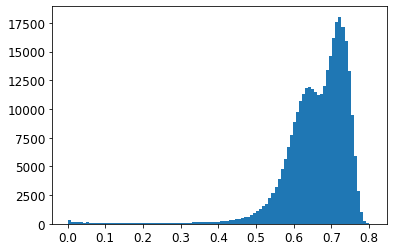

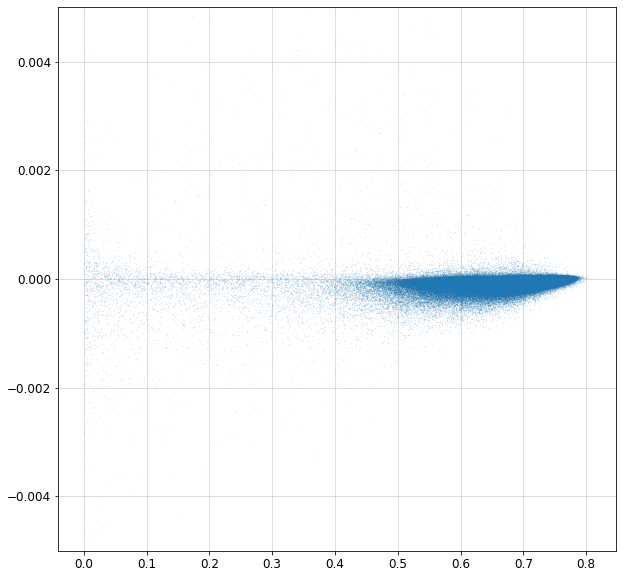

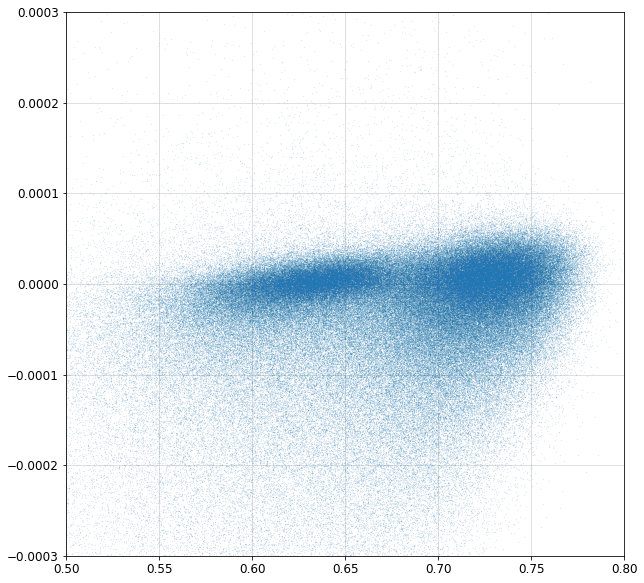

In [9]:
plt.hist(cat['frac'], 100)
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(cat['frac'], cat['g_median_arcsec'], '.', ms=0.1)
plt.ylim(-0.005, 0.005)
plt.grid(alpha=0.5)
plt.show()

mask = np.ones(len(cat), dtype=bool)
plt.figure(figsize=(10, 10))
plt.plot(cat['frac'][mask], cat['g_median_arcsec'][mask], '.', ms=0.1)
plt.axis([0.5, 0.8, -0.0003, 0.0003])
plt.grid(alpha=0.5)
plt.show()

In [10]:
# mask = cat['frac']<0.3
# print(np.sum(mask), np.sum(mask)/len(cat))
# cat = cat[~mask]

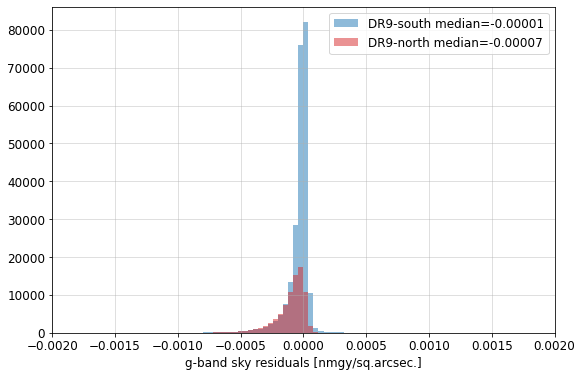

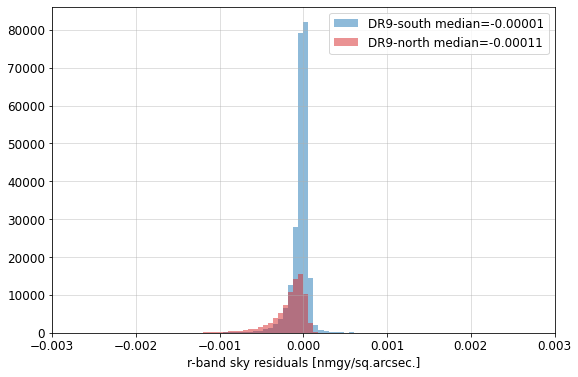

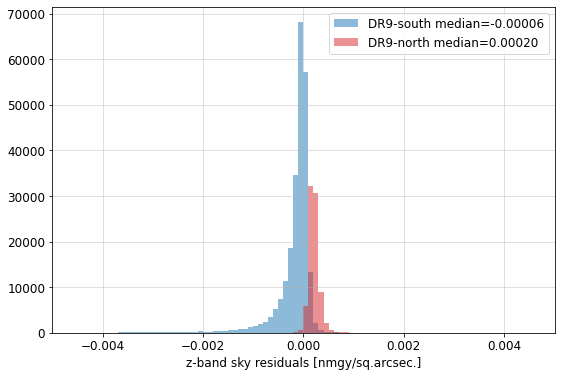

In [11]:
vrange_list = [0.002, 0.003, 0.005]

for band, vrange in zip(['g', 'r', 'z'], vrange_list):
    plt.figure(figsize=(9, 6))
    v = cat[band+'_median_arcsec'][cat['region']=='south']
    plt.hist(v, 100, range=(-vrange, vrange), color='C0', alpha=0.5, label='DR9-south median={:.5f}'.format(np.median(v)), density=False)
    v = cat[band+'_median_arcsec'][cat['region']=='north']
    plt.hist(v, 100, range=(-vrange, vrange), color='C3', alpha=0.5, label='DR9-north median={:.5f}'.format(np.median(v)), density=False)
    plt.xlim(-vrange, vrange)
    plt.xlabel(band+'-band sky residuals [nmgy/sq.arcsec.]')
    plt.grid(alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [15]:
%%time

vrange_list = [0.001, 0.0015, 0.002]

for band, vrange in zip(['g', 'r', 'z'], vrange_list):

    mask = np.ones(len(cat), dtype=bool)
    ra1, dec1, ra2, dec2, c = cat['RA1'][mask], cat['DEC1'][mask], cat['RA2'][mask], cat['DEC2'][mask], cat[band+'_median_arcsec'][mask]
    # extend the brick boundaries to avoid visible boundaries in the plot
    ra1, ra2 = ra1 - 0.02/np.cos(np.radians(dec1)), ra2 + 0.02/np.cos(np.radians(dec1))
    dec1, dec2 = dec1 - 0.02, dec2 + 0.02
    rot = 120

    x1 = np.remainder(ra1+360-rot, 360) # shift ra values
    x2 = ra2 + (x1-ra1)
    xmask = x1>180
    x1[xmask] -= 360  # scale conversion to [-180, 180]
    x1 = -x1
    x2[xmask] -= 360  # scale conversion to [-180, 180]
    x2 = -x2
    x1, x2, y1, y2 = np.radians([x1, x2, dec1, dec2])
    coords = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
    coords = np.swapaxes(np.swapaxes(coords, 0, 2), 1, 2)

    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+rot, 360)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='mollweide')

    # idx = np.random.choice(len(cat), size=1000, replace=False)
    # coords, c = coords[idx], c[idx]
    collect = PolyCollection(coords, array=c)
    collect.set_clim(-vrange, vrange)
    collect.set_cmap('seismic')
    im = ax.add_collection(collect)

    ax.set_xticklabels(tick_labels)
    ax.set_title(band+'-band sky residuals [nmgy/sq.arcsec.]', y=-0.165)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("DEC")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    plt.colorbar(im, orientation="horizontal", fraction=0.04, pad=0.04, aspect=32)
    plt.tight_layout()
    plt.savefig('plots/{}_brick_sky.png'.format(band), dpi=300)
    plt.close()

CPU times: user 16min 46s, sys: 25.8 s, total: 17min 11s
Wall time: 17min 12s


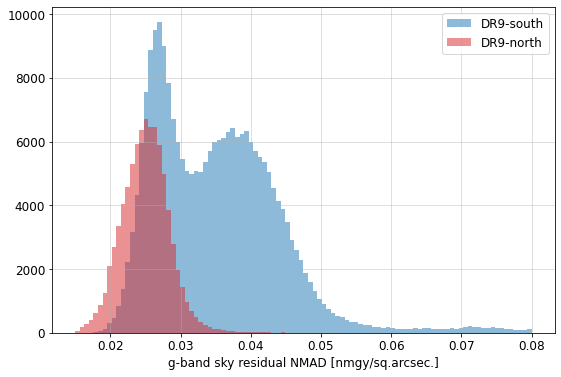

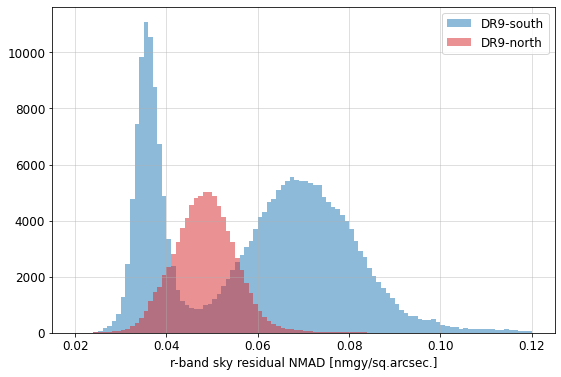

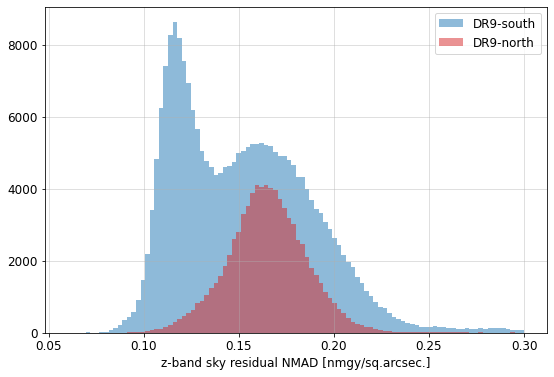

In [18]:
vrange_list = [[0.015, 0.08], [0.02, 0.12], [0.06, 0.3]]

for band, vrange in zip(['g', 'r', 'z'], vrange_list):
    plt.figure(figsize=(9, 6))
    v = cat[band+'_nmad_arcsec'][cat['region']=='south']
    plt.hist(v, 100, range=vrange, color='C0', alpha=0.5, label='DR9-south', density=False)
    v = cat[band+'_nmad_arcsec'][cat['region']=='north']
    plt.hist(v, 100,  range=vrange, color='C3', alpha=0.5, label='DR9-north', density=False)
#     plt.xlim(-vrange, vrange)
    plt.xlabel(band+'-band sky residual NMAD [nmgy/sq.arcsec.]')
    plt.grid(alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [19]:
%%time

vrange_list = [[0.015, 0.08], [0.02, 0.12], [0.06, 0.3]]

for band, vrange in zip(['g', 'r', 'z'], vrange_list):

    mask = np.ones(len(cat), dtype=bool)
    ra1, dec1, ra2, dec2, c = cat['RA1'][mask], cat['DEC1'][mask], cat['RA2'][mask], cat['DEC2'][mask], cat[band+'_nmad_arcsec'][mask]
    # extend the brick boundaries to avoid visible boundaries in the plot
    ra1, ra2 = ra1 - 0.02/np.cos(np.radians(dec1)), ra2 + 0.02/np.cos(np.radians(dec1))
    dec1, dec2 = dec1 - 0.02, dec2 + 0.02
    rot = 120

    x1 = np.remainder(ra1+360-rot, 360) # shift ra values
    x2 = ra2 + (x1-ra1)
    xmask = x1>180
    x1[xmask] -= 360  # scale conversion to [-180, 180]
    x1 = -x1
    x2[xmask] -= 360  # scale conversion to [-180, 180]
    x2 = -x2
    x1, x2, y1, y2 = np.radians([x1, x2, dec1, dec2])
    coords = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
    coords = np.swapaxes(np.swapaxes(coords, 0, 2), 1, 2)

    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+rot, 360)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='mollweide')

    # idx = np.random.choice(len(cat), size=1000, replace=False)
    # coords, c = coords[idx], c[idx]
    collect = PolyCollection(coords, array=c)
    collect.set_clim(vrange[0], vrange[1])
    collect.set_cmap('viridis')
    im = ax.add_collection(collect)

    ax.set_xticklabels(tick_labels)
    ax.set_title(band+'-band sky residual NMAD [nmgy/sq.arcsec.]', y=-0.165)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("DEC")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    plt.colorbar(im, orientation="horizontal", fraction=0.04, pad=0.04, aspect=32)
    plt.tight_layout()
    plt.savefig('plots/{}_brick_sky_nmad.png'.format(band), dpi=300)
    plt.close()

CPU times: user 15min 20s, sys: 22.7 s, total: 15min 42s
Wall time: 15min 39s
